<a href="https://colab.research.google.com/github/chiknpot/ShootingCorn/blob/front/available_GUN_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
###pharsing

import cv2
import os
num = 0
print(cv2.__version__)
vidcap = cv2.VideoCapture('/content/gdrive/My Drive/darknet_detect/video/gun_video.mp4')
success,image = vidcap.read()
count = 0
save_count = 0
success = True
while success:
    if(int(vidcap.get(1)) % 25 == 0):
        print('Saved frame number : ' + str(int(vidcap.get(1))))

        path = '/content/gdrive/My Drive/darknet_detect/video_cut/'
        num += 1
        cv2.imwrite(os.path.join(path, "frame%d.png" % num), image)  
        save_count += 1
    success,image = vidcap.read()
    print ('Read a new frame: ', success)
    count += 1

4.1.2
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Saved frame number : 25
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new

In [ ]:
cd /content/gdrive/My Drive/darknet_detect/

/content/gdrive/My Drive/darknet_detect


In [ ]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# display function to show image on Jupyter
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

In [ ]:
# Load the COCO class labels in which our YOLO model was trained on

labelsPath = os.path.join("/content/gdrive/My Drive/darknet_detect/data/yolo.names")
LABELS = open(labelsPath).read().strip().split("\n")

In [ ]:
# The COCO dataset contains 80 different classes
LABELS

['gun']

In [ ]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join("/content/gdrive/My Drive/darknet_detect/yolov3_900.weights")
configPath = os.path.join("/content/gdrive/My Drive/darknet_detect/cfg/yolov3_custom_train.cfg")

In [ ]:
# Loading the neural network framework Darknet (YOLO was created based on this framework)
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [ ]:
global d 
# Create the function which predict the frame input
def predict(image):
    global d 
    d = 0
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (255,0,0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]], confidences[i])

            
            d = 3
            #print(d)
            #print("이것은 detection안에서 출력된 d\n\n")

            cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2)
    return image

In [ ]:
import os

path = "/content/gdrive/My Drive/darknet_detect/video_cut/"
file_list = os.listdir(path)

print ("file_list: {}".format(file_list))
print(file_list[0])

file_list: ['frame1.png', 'frame2.png', 'frame3.png', 'frame4.png', 'frame5.png', 'frame6.png', 'frame7.png', 'frame8.png', 'frame9.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png', 'frame14.png', 'frame15.png', 'frame16.png', 'frame17.png', 'frame18.png', 'frame19.png']
frame1.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


image detected point:   2 sec
image detected point:   4 sec
image detected point:   7 sec
image detected point:   12 sec
image detected point:   13 sec


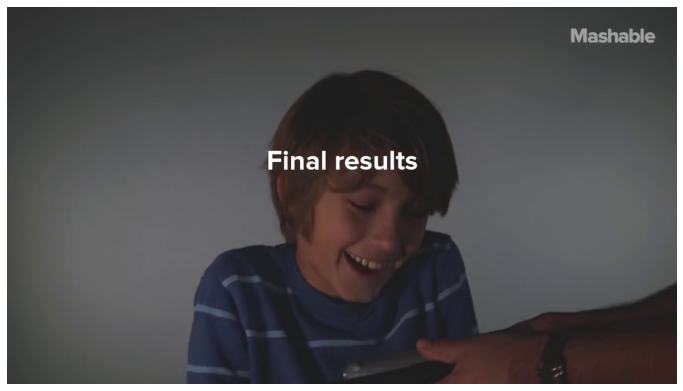

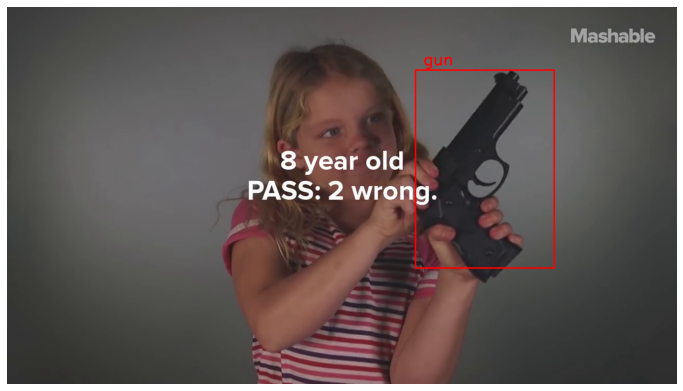

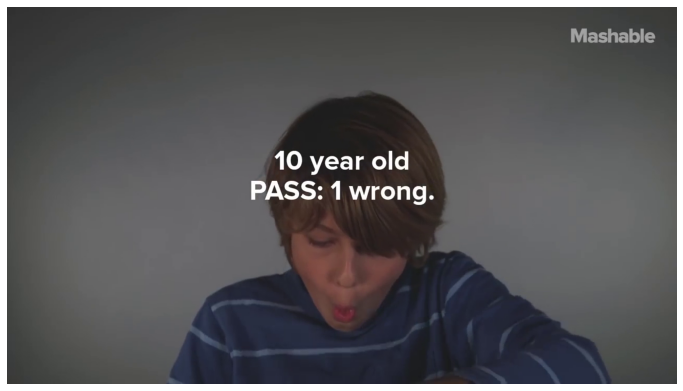

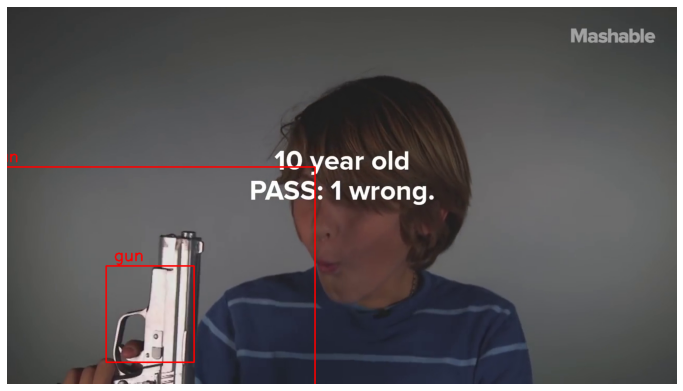

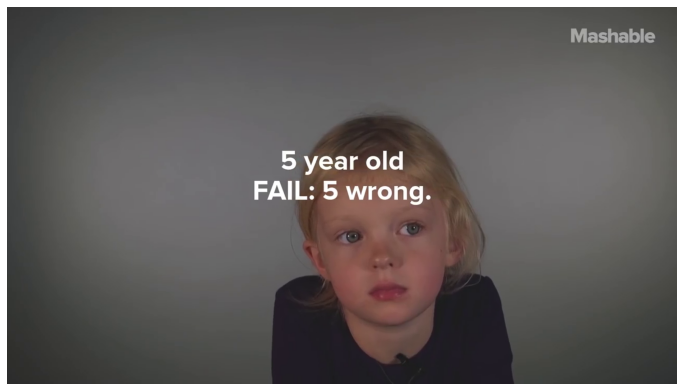

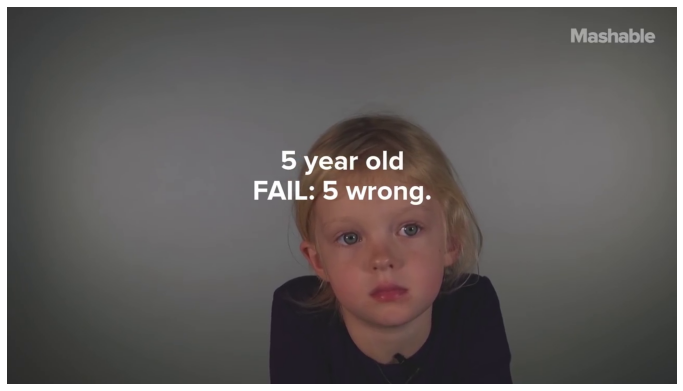

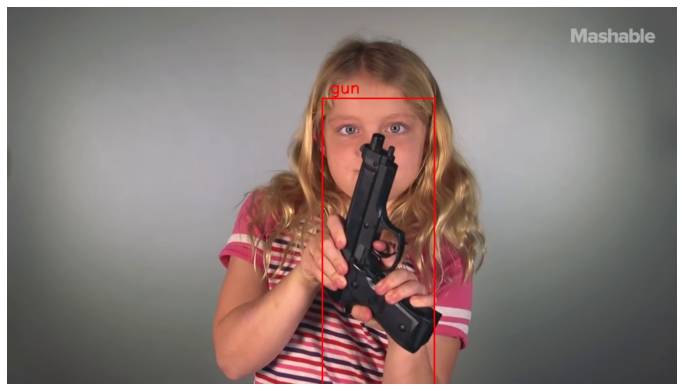

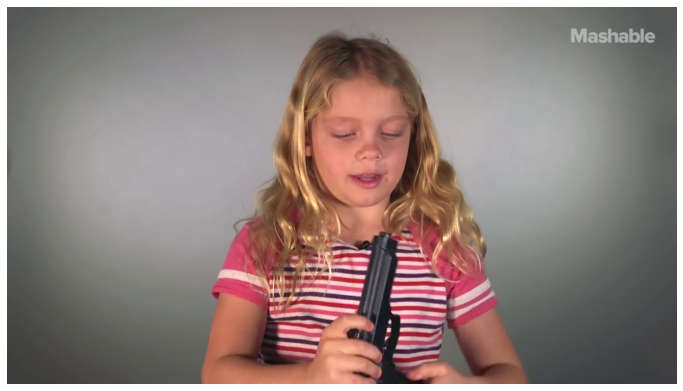

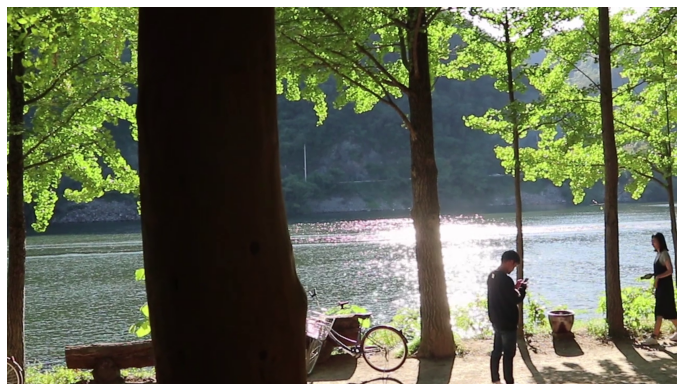

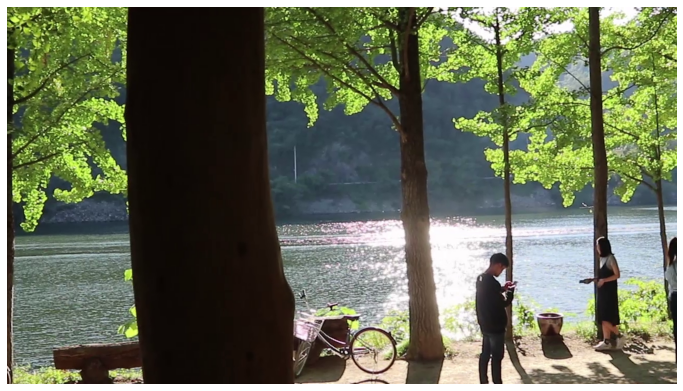

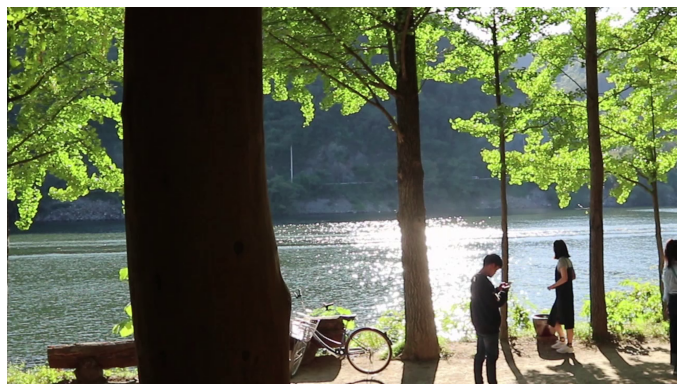

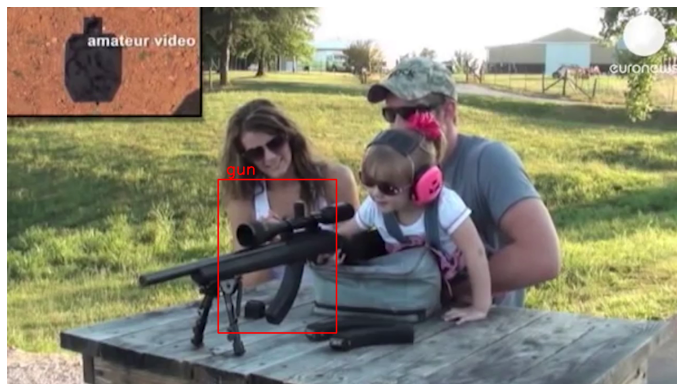

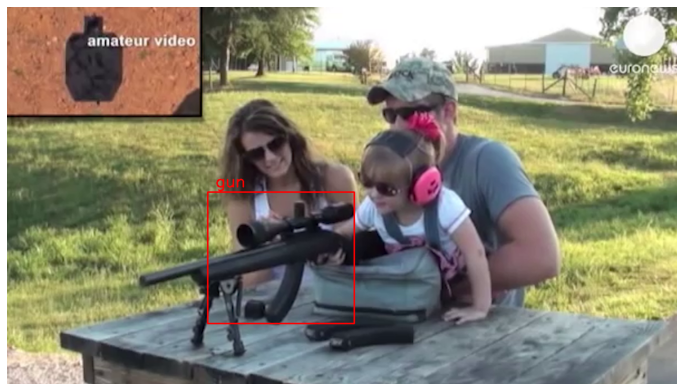

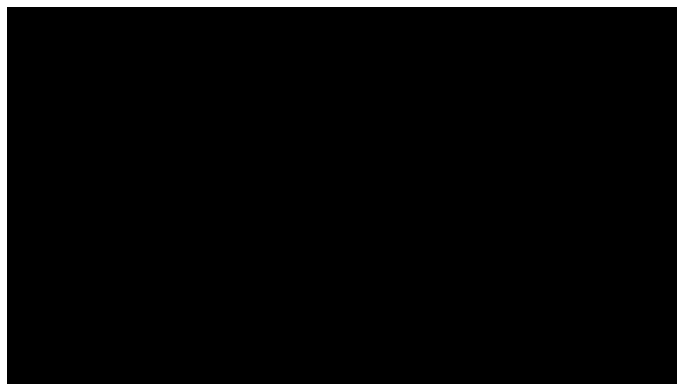

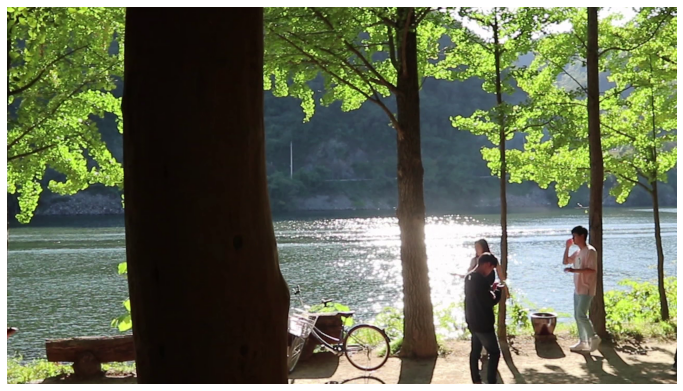

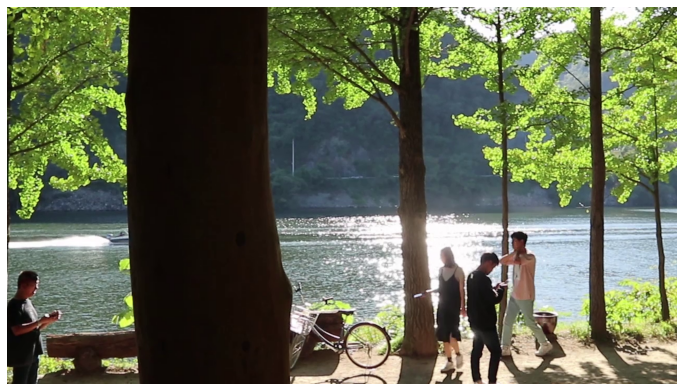

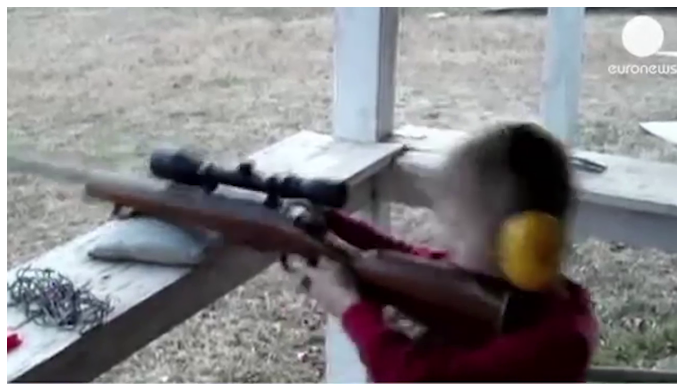

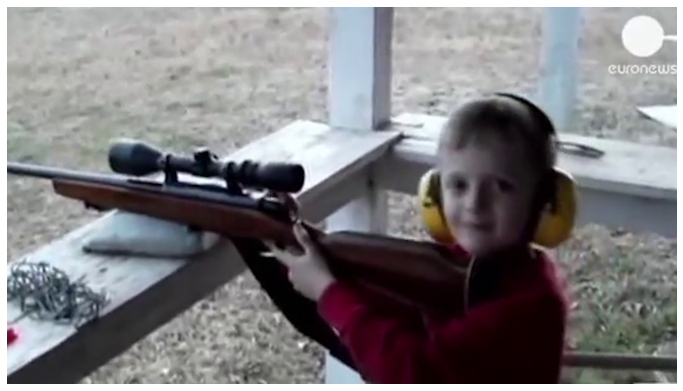

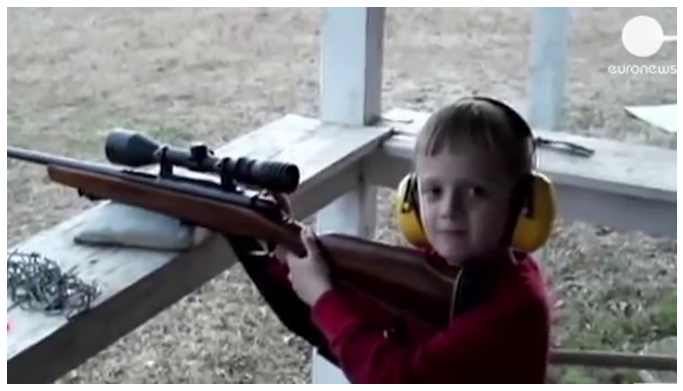

In [ ]:

# Execute prediction on a single image
#img = cv2.imread("/content/gdrive/My Drive/darknet_detect/video_cut/IMG_8418.JPG")

#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


i = 0
count = len(file_list)
for i in range(i, count) :
  img = cv2.imread("/content/gdrive/My Drive/darknet_detect/video_cut/" + file_list[i])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  display_img(predict(img))

  if d == 3:
    print("image detected point:  ", i+1,  "sec")
    



In [ ]:
pip install web.py

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 92kB 7.5MB/s 
  Created wheel for web.py: filename=web.py-0.51-cp36-none-any.whl size=89247 sha256=a8c04fe78681c46354f1c11eccb4eb498072e14d6aa5b4dea2855d350e80736b
  Stored in directory: /root/.cache/pip/wheels/59/13/3f/e51ca58ea933334f0f619d0dfbba9d7d7ee49fc51e163c6ad7
Successfully built web.py


In [ ]:
### Apply Yolov3 for object dectection on a video

cap =cv2.VideoCapture('/content/gdrive/My Drive/darknet_detect/gun_1.mp4')

number_frame = 30.0 #higher frames better quality of the video
video_size = (1280,720)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('gun_detection.mp4',fourcc, number_frame,video_size)

while True:
    ret,frame = cap.read() 
    
    if ret:
        
        frame = cv2.resize(frame, (1280,720))
        frame = predict(frame)
        cv2.imshow("image",frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
        
cap.release()   
out.release()
cv2.destroyAllWindows()